In [1]:
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

#from util import load_data, cindex

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).


In [2]:
import os
import lifelines
class Utils:
    @staticmethod
    def cindex(y_true, scores):
        return lifelines.utils.concordance_index(y_true, scores)
    
    @staticmethod
    def load_data(threshold):
        X, y = Utils.nhanesi()
        df = X.drop([X.columns[0]], axis=1)
        df.loc[:, 'time'] = y
        df.loc[:, 'death'] = np.ones(len(X))
        df.loc[df.time < 0, 'death'] = 0
        df.loc[:, 'time'] = np.abs(df.time)
        df = df.dropna(axis='rows')
        mask = (df.time > threshold) | (df.death == 1)
        df = df[mask]
        X = df.drop(['time', 'death'], axis='columns')
        y = df.time < threshold

        X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
        feature_y = 'Systolic BP'
        frac = 0.7

        drop_rows = X_dev.sample(frac=frac, replace=False,
                                 weights=[Utils.prob_drop(X_dev.loc[i, 'Age']) for i in
                                          X_dev.index], random_state=10)
        drop_rows.loc[:, feature_y] = None
        drop_y = y_dev[drop_rows.index]
        X_dev.loc[drop_rows.index, feature_y] = None

        return X_dev, X_test, y_dev, y_test
    
    @staticmethod
    def prob_drop(age):
        return 1 - (np.exp(0.25 * age - 5) / (1 + np.exp(0.25 * age - 5)))

    @staticmethod
    def nhanesi(display=False):
        """Same as shap, but we use local data."""
        X = pd.read_csv(os.path.join('a02/NHANESI_subset_X.csv'))
        y = pd.read_csv(os.path.join('a02/NHANESI_subset_y.csv'))["y"]
        if display:
            X_display = X.copy()
            X_display["Sex"] = ["Male" if v == 1 else "Female" for v in X["Sex"]]
            return X_display, np.array(y)
        return X, np.array(y)


In [3]:
X_dev, X_test, y_dev, y_test = Utils.load_data(10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=10)

In [5]:
print("X_train shape: {}".format(X_train.shape))
X_train.head()

X_train shape: (5147, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
1599,43.0,84.0,637.0,1.0,49.3,10.0,5.0,253.0,134.0,1.59,7.7,1.0,NaN,490.0,27.3,9.1,25.803007,34.0
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
1182,54.0,78.0,205.0,1.0,43.8,12.0,4.2,206.0,180.0,1.67,6.6,2.0,NaN,363.0,49.6,5.9,20.278410,34.0
6915,59.0,90.0,417.0,1.0,43.4,9.0,4.5,327.0,114.0,1.65,7.6,2.0,NaN,347.0,32.9,6.1,32.917744,78.0
500,34.0,80.0,385.0,1.0,77.7,9.0,4.1,197.0,64.0,1.74,7.3,2.0,NaN,376.0,17.0,8.2,30.743489,30.0


In [6]:
y_train.head(20)

1599    False
2794     True
1182    False
6915    False
500     False
1188     True
9739    False
3266    False
6681    False
8822    False
5856     True
3415    False
9366    False
7975    False
1397    False
6809    False
9461    False
9374    False
1170     True
158     False
Name: time, dtype: bool

In [7]:
i = 10
print(X_train.iloc[i,:])
print("\nDied within 10 years? {}".format(y_train.loc[y_train.index[i]]))

Age                    67.000000
Diastolic BP           94.000000
Poverty index         114.000000
Race                    1.000000
Red blood cells        43.800000
Sedimentation rate     12.000000
Serum Albumin           3.700000
Serum Cholesterol     178.000000
Serum Iron             73.000000
Serum Magnesium         1.850000
Serum Protein           7.000000
Sex                     1.000000
Systolic BP           140.000000
TIBC                  311.000000
TS                     23.500000
White blood cells       4.300000
BMI                    17.481227
Pulse pressure         46.000000
Name: 5856, dtype: float64

Died within 10 years? True


## Dealing with Missing Data

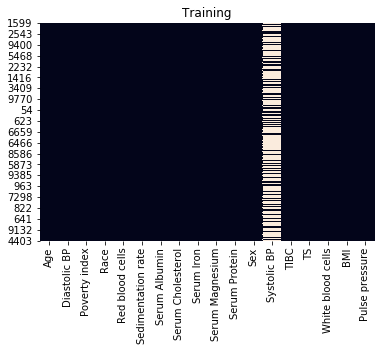

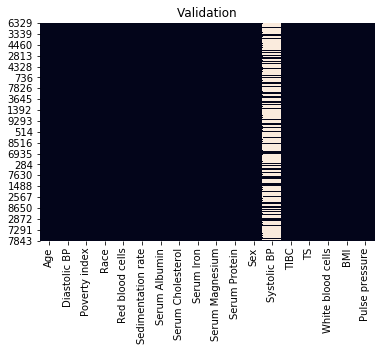

In [8]:
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

sns.heatmap(X_val.isnull(), cbar=False)
plt.title("Validation")
plt.show()

In [9]:
def fraction_rows_missing(df):
    null_rows = df.isnull().any(axis=1)
    return len(df[null_rows])/len(df)

In [10]:
df_test = pd.DataFrame({'a':[None, 1, 1, None], 'b':[1, None, 0, 1]})
print("Example dataframe:\n")
print(df_test)

print("\nComputed fraction missing: {}, expected: {}".format(fraction_rows_missing(df_test), 0.75))
print(f"Fraction of rows missing from X_train: {fraction_rows_missing(X_train):.3f}")
print(f"Fraction of rows missing from X_val: {fraction_rows_missing(X_val):.3f}")
print(f"Fraction of rows missing from X_test: {fraction_rows_missing(X_test):.3f}")

Example dataframe:

     a    b
0  NaN  1.0
1  1.0  NaN
2  1.0  0.0
3  NaN  1.0

Computed fraction missing: 0.75, expected: 0.75
Fraction of rows missing from X_train: 0.699
Fraction of rows missing from X_val: 0.704
Fraction of rows missing from X_test: 0.000


In [11]:
X_train_dropped = X_train.dropna(axis='rows')
y_train_dropped = y_train.loc[X_train_dropped.index]
X_val_dropped = X_val.dropna(axis='rows')
y_val_dropped = y_val.loc[X_val_dropped.index]

## Decision Trees

In [12]:
dt = DecisionTreeClassifier(max_depth=None, random_state=10)
dt.fit(X_train_dropped, y_train_dropped)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')

In [13]:
y_train_preds = dt.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {Utils.cindex(y_train_dropped.values, y_train_preds)}")

y_val_preds = dt.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {Utils.cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 1.0
Val C-Index: 0.5629321808510638


In [14]:
dt_hyperparams = {
    'criterion': 'entropy',
    'min_samples_split': 0.5,
    'max_depth': 15
}

In [15]:
dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train_dropped, y_train_dropped)

y_train_preds = dt_reg.predict_proba(X_train_dropped)[:, 1]
y_val_preds = dt_reg.predict_proba(X_val_dropped)[:, 1]
print(f"Train C-Index: {Utils.cindex(y_train_dropped.values, y_train_preds)}")


Train C-Index: 0.6201372530835575


In [16]:
dot_data = StringIO()
export_graphviz(
    dt_reg, feature_names=X_train_dropped.columns, 
    out_file=dot_data, filled=True, rounded=True, 
    proportion=True, special_characters=True, impurity=False, 
    class_names=['neg', 'pos'], precision=2
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#Image(graph.create_png())

## Random Forests

In [17]:
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(X_train_dropped, y_train_dropped)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [18]:
y_train_rf_preds = rf.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {Utils.cindex(y_train_dropped.values, y_train_rf_preds)}")


y_val_rf_preds = rf.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {Utils.cindex(y_val_dropped.values, y_val_rf_preds)}")

Train C-Index: 1.0
Val C-Index: 0.6660488696808511


In [19]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparams, fixed_hyperparams={}):
    best_estimator = None
    best_hyperparams = {}
    
    best_score = 0.0
    lists = hyperparams.values()
    
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)
    
    for i, params in enumerate(param_combinations, 1):
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
            
        # create enstimator with specified params
        estimator = clf(**param_dict, **fixed_hyperparams)
        
        # fit estimator
        estimator.fit(X_train_hp, y_train_hp)
        
        # Get predictions on validation set
        preds = estimator.predict_proba(X_val_hp)
        
        # Compute cindex for predictions
        estimator_score = Utils.cindex(y_val_hp, preds[:, 1])
        
        print(f"[{i}/{total_param_combinations}] {param_dict}")
        print(f"Val C-Index: {estimator_score}\n")
        
        if(estimator_score >= best_score):
            best_score = estimator_score
            best_estimator = estimator
            best_hyperparams = param_dict
            
    best_hyperparams.update(fixed_hyperparams)
        
    return best_estimator, best_hyperparams

In [20]:
np.arange(1, 10)
np.concatenate((np.arange(0.1, 0.51, 0.02), np.arange(2, 20)))


array([ 0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,  0.22,  0.24,  0.26,
        0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,  0.4 ,  0.42,  0.44,
        0.46,  0.48,  0.5 ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,
        8.  ,  9.  , 10.  , 11.  , 12.  , 13.  , 14.  , 15.  , 16.  ,
       17.  , 18.  , 19.  ])

In [72]:
def random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped):
    hyperparams = {
        "n_estimators": np.arange(100, 150, 10),
        'max_depth': np.arange(1, 100, 10),
        'min_samples_leaf': [0.1, 0.2,0.3, 0.4, 0.5, 2, 3, 4, 5]
    }
    hyperparams = {
        "n_estimators": np.arange(100, 110),
        'max_depth': np.arange(1, 2),
        'min_samples_leaf': [0.1, 0.2]
    }
    fixed_hyperparams = {
        'random_state': 10,
    }
    rf = RandomForestClassifier
    
    best_rf, best_hyperparams = holdout_grid_search(
        rf, X_train_dropped, y_train_dropped,
        X_val_dropped, y_val_dropped, hyperparams,
        fixed_hyperparams
    )
    print(f"Best Hyperparams: \n {best_hyperparams}")
    
    y_train_best = best_rf.predict_proba(X_train_dropped)[:, 1]
    print(f"Train C-Index: {Utils.cindex(y_train_dropped, y_train_best)}")
    
    y_val_best = best_rf.predict_proba(X_val_dropped)[:, 1]
    print(f"Val C-Index: {Utils.cindex(y_val_dropped, y_val_best)}")
    
    best_hyperparams.update(fixed_hyperparams)
    
    return best_rf, best_hyperparams

In [73]:
best_rf, best_hyperparams = random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped)

[1/20] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 0.1}
Val C-Index: 0.6570063164893617

[2/20] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 0.2}
Val C-Index: 0.6635388962765958

[3/20] {'n_estimators': 101, 'max_depth': 1, 'min_samples_leaf': 0.1}
Val C-Index: 0.6571392952127659

[4/20] {'n_estimators': 101, 'max_depth': 1, 'min_samples_leaf': 0.2}
Val C-Index: 0.6634059175531914

[5/20] {'n_estimators': 102, 'max_depth': 1, 'min_samples_leaf': 0.1}
Val C-Index: 0.6580369015957447

[6/20] {'n_estimators': 102, 'max_depth': 1, 'min_samples_leaf': 0.2}
Val C-Index: 0.6643201462765957

[7/20] {'n_estimators': 103, 'max_depth': 1, 'min_samples_leaf': 0.1}
Val C-Index: 0.6590841090425532

[8/20] {'n_estimators': 103, 'max_depth': 1, 'min_samples_leaf': 0.2}
Val C-Index: 0.665201130319149

[9/20] {'n_estimators': 104, 'max_depth': 1, 'min_samples_leaf': 0.1}
Val C-Index: 0.6587849069148937

[10/20] {'n_estimators': 104, 'max_depth': 1, 'min_samples_leaf': 0.2}
Val

In [24]:
y_test_best = best_rf.predict_proba(X_test)[:, 1]
print(f"Test C-Index: {Utils.cindex(y_test.values, y_test_best)}")

Test C-Index: 0.6838677692924349


## Imputation

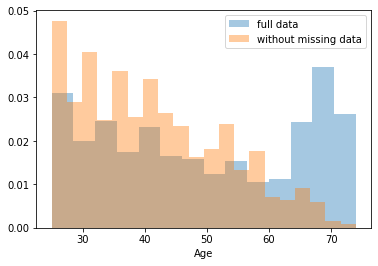

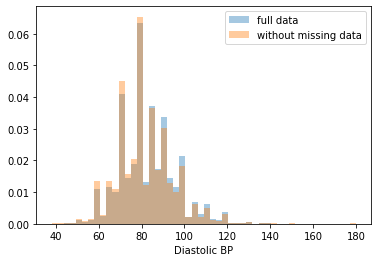

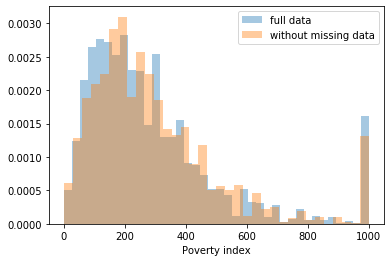

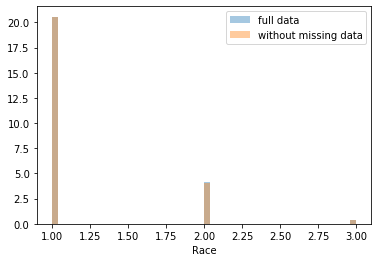

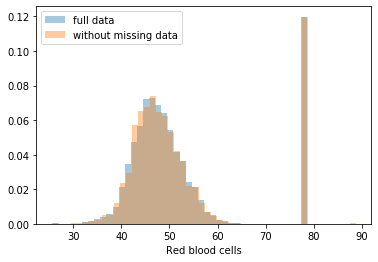

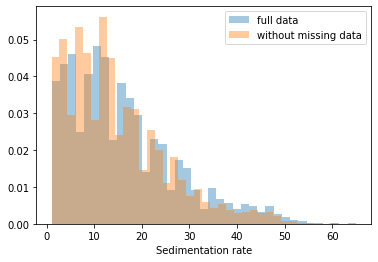

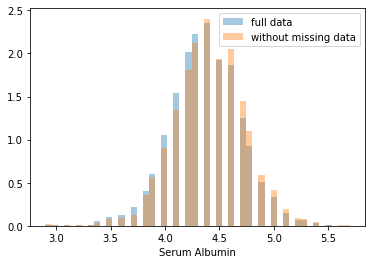

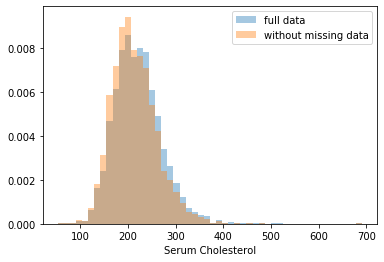

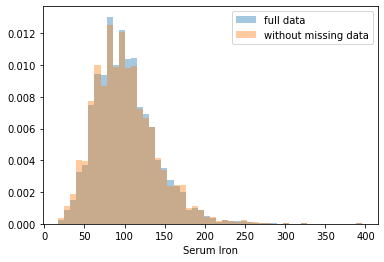

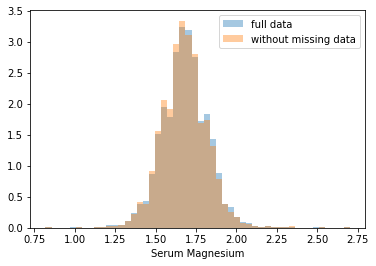

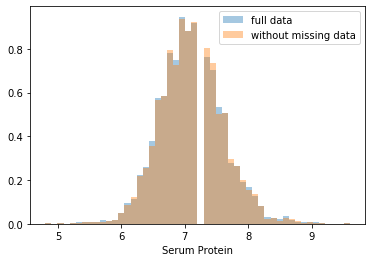

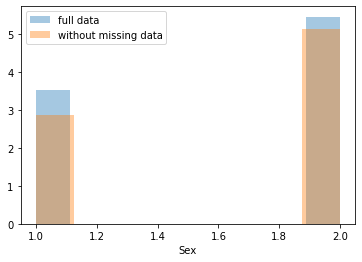

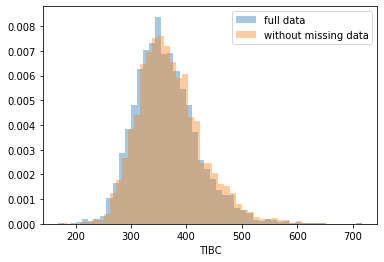

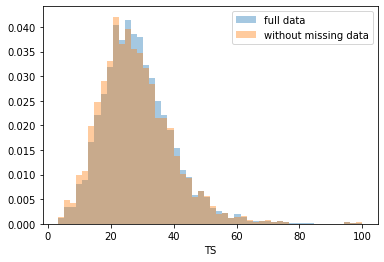

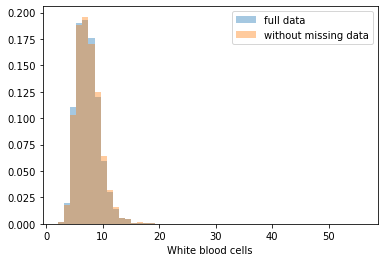

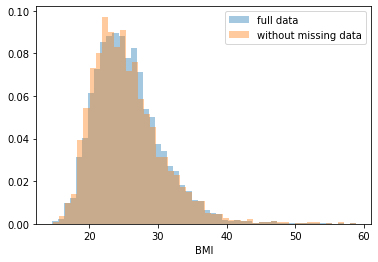

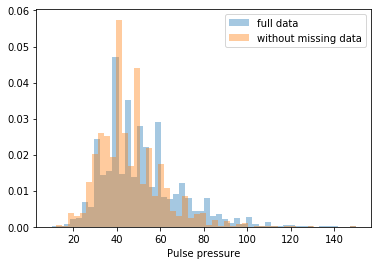

In [25]:
dropped_rows = X_train[X_train.isnull().any(axis=1)]

columns_except_Systolic_BP = [
    col for col in X_train.columns if col not in['Systolic BP']
]

for col in columns_except_Systolic_BP:
    sns.distplot(X_train.loc[:, col], norm_hist=True, kde=False, label='full data')
    sns.distplot(dropped_rows.loc[:, col], norm_hist=True, kde=False, label='without missing data')
    plt.legend()
    
    plt.show()

## Error Analysis

In [46]:
def bad_subset(forest, X_test, y_test):
    mask = (X_test['Age'] > 67)
    X_subgroup = X_test[mask]
    y_subgroup = y_test[mask]
    subgroup_size = len(X_subgroup)
    
    y_subgroup_preds = forest.predict_proba(X_subgroup)[:, 1]
    performance = Utils.cindex(y_subgroup.values, y_subgroup_preds)
    
    return performance, subgroup_size

In [47]:
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print("Subgroup size should greater than 250, performance should be less than 0.69 ")
print(f"Subgroup size: {subgroup_size}, C-Index: {performance}")

Subgroup size should greater than 250, performance should be less than 0.69 
Subgroup size: 320, C-Index: 0.6831426212103339


## Imputation Approaches

In [48]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_mean_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_mean_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

In [68]:
hyperparams = {
    'n_estimators': np.arange(100, 150, 15),
    'max_depth': np.arange(1, 100, 10),
    'min_samples_leaf': [0.1, 0.2,0.3, 0.4, 0.5, 2, 3, 4, 5],
}
hyperparams = {
    'n_estimators': [100, 110],
    'max_depth': [1, 2],
    'min_samples_leaf': [0.1, 0.2, 4, 5],
}

In [69]:
rf = RandomForestClassifier

rf_mean_imputed, best_hyperparams_mean_imputed = holdout_grid_search(
    rf, X_train_mean_imputed, y_train,
    X_val_mean_imputed, y_val,
    hyperparams, {'random_state': 10}
)
print("Performance for best hyperparameters:")

y_train_best = rf_mean_imputed.predict_proba(X_train_mean_imputed)[:, 1]
print(f"- Train C-Index: {Utils.cindex(y_train, y_train_best):.4f}")

y_val_best = rf_mean_imputed.predict_proba(X_val_mean_imputed)[:, 1]
print(f"- Val C-Index: {Utils.cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_mean_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {Utils.cindex(y_test, y_test_imp):.4f}")

[1/16] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 0.1}
Val C-Index: 0.7171716184731369

[2/16] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 0.2}
Val C-Index: 0.7135769174814728

[3/16] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 4}
Val C-Index: 0.7141512445200081

[4/16] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 5}
Val C-Index: 0.7141512445200081

[5/16] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 0.1}
Val C-Index: 0.728654902190694

[6/16] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 0.2}
Val C-Index: 0.7152152152152152

[7/16] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 4}
Val C-Index: 0.7315851643400451

[8/16] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 5}
Val C-Index: 0.7315178519083074

[9/16] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 0.1}
Val C-Index: 0.7181378775738863

[10/16] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 0.2}
Val C-Index

In [54]:
# Impute using regression on other covariates
imputer = IterativeImputer(random_state=0, sample_posterior=False, max_iter=1, min_value=0)
imputer.fit(X_train)
X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

[IterativeImputer] Early stopping criterion not reached.


In [66]:
hyperparams = {
    'n_estimators': np.arange(100, 150, 15),
    'max_depth': np.arange(1, 100, 10),
    'min_samples_leaf': [0.1, 0.2,0.3, 0.4, 0.5, 2, 3, 4, 5],
}

hyperparams = {
    'n_estimators': [100, 110],
    'max_depth': [1, 2],
    'min_samples_leaf': [0.1, 0.2, 4, 5],
}

In [67]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
rf = RandomForestClassifier

rf_imputed, best_hyperparams_imputed = holdout_grid_search(rf, X_train_imputed, y_train,
                                                           X_val_imputed, y_val,
                                                           hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")

y_train_best = rf_imputed.predict_proba(X_train_imputed)[:, 1]
print(f"- Train C-Index: {Utils.cindex(y_train, y_train_best):.4f}")

y_val_best = rf_imputed.predict_proba(X_val_imputed)[:, 1]
print(f"- Val C-Index: {Utils.cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {Utils.cindex(y_test, y_test_imp):.4f}")

[1/16] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 0.1}
Val C-Index: 0.7120819300862685

[2/16] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 0.2}
Val C-Index: 0.7094556595641194

[3/16] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 4}
Val C-Index: 0.7125889446930662

[4/16] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 5}
Val C-Index: 0.7125889446930662

[5/16] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 0.1}
Val C-Index: 0.7227780926262488

[6/16] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 0.2}
Val C-Index: 0.7105999709036586

[7/16] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 4}
Val C-Index: 0.728389995201275

[8/16] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 5}
Val C-Index: 0.7283682815136178

[9/16] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 0.1}
Val C-Index: 0.7137712549860056

[10/16] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 0.2}
Val C-Index

## Comparison

In [58]:
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print(f"C-Index (no imputation): {performance}")

performance, subgroup_size = bad_subset(rf_mean_imputed, X_test, y_test)
print(f"C-Index (mean imputation): {performance}")

performance, subgroup_size = bad_subset(rf_imputed, X_test, y_test)
print(f"C-Index (multivariate feature imputation): {performance}")

C-Index (no imputation): 0.6831426212103339
C-Index (mean imputation): 0.6759073571625182
C-Index (multivariate feature imputation): 0.6872321182808383


## Explanations: SHAP

In [60]:
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = rf_imputed.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
2044,74.0,80.0,83.0,1.0,47.6,19.0,4.2,205.0,72.0,1.71,6.9,1.0,180.0,310.0,23.2,10.8,20.900101,100.0,0.677584
6337,69.0,80.0,233.0,1.0,77.7,48.0,4.2,159.0,87.0,1.81,6.9,1.0,146.0,291.0,29.9,15.2,17.931276,66.0,0.670930
5493,67.0,80.0,30.0,1.0,77.7,59.0,3.4,231.0,36.0,1.40,6.3,1.0,170.0,202.0,17.8,8.4,17.029470,90.0,0.664149
6609,72.0,90.0,75.0,1.0,29.3,59.0,3.9,216.0,64.0,1.63,7.4,2.0,182.0,322.0,19.9,9.3,22.281793,92.0,0.655495
2608,71.0,80.0,104.0,1.0,43.8,23.0,4.0,201.0,119.0,1.60,7.0,1.0,166.0,311.0,38.3,6.3,17.760766,86.0,0.636308


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


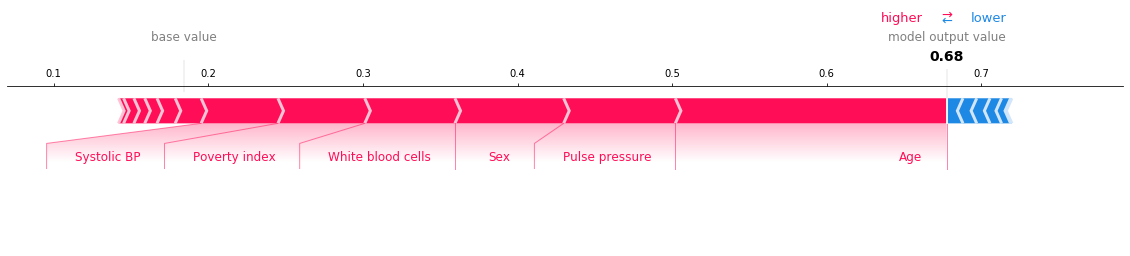

In [61]:
explainer = shap.TreeExplainer(rf_imputed)
i = 0
shap_value = explainer.shap_values(X_test.loc[X_test_risk.index[i], :])[1]
shap.force_plot(
    explainer.expected_value[1], shap_value,
    feature_names=X_test.columns, matplotlib=True
)

In [62]:
shap_values = shap.TreeExplainer(rf_imputed).shap_values(X_test)[1]

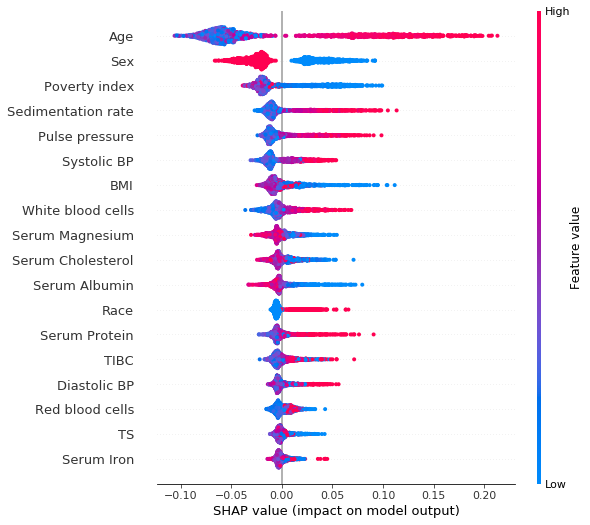

In [63]:
shap.summary_plot(shap_values, X_test)

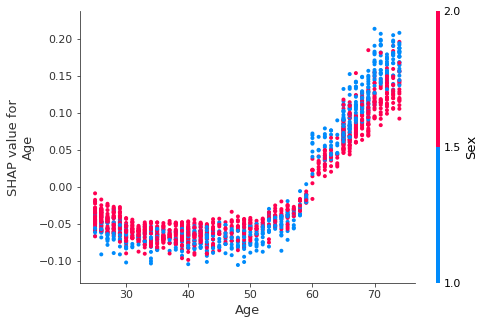

In [64]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='Sex')

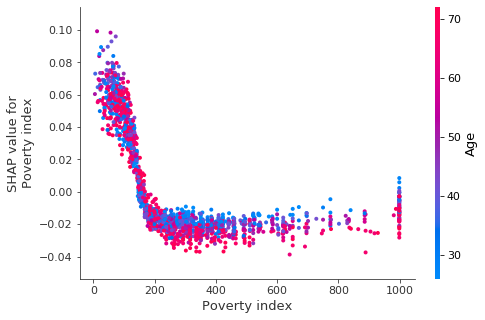

In [65]:
shap.dependence_plot('Poverty index', shap_values, X_test, interaction_index='Age')